In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from tensorflow.keras import backend as K
from tensorflow.keras.utils import CustomObjectScope

In [2]:
prev_frame_time = 0
new_frame_time = 0

H = 256
W = 256

In [3]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


def mad(y_true, y_pred):
    return backend.mean(abs(y_pred - y_true))


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [4]:
with CustomObjectScope({'dice_coef': dice_coef, 'dice_loss': dice_loss, 'mad':mad}):
    model = tf.keras.models.load_model("../../final-model/mobilenetv3_unet_single_frame.h5")

In [5]:
imgBg = cv2.imread("../../bg/1.jpg")
listImg = os.listdir("../../bg")
indexImg = 0

imgList = []
for imgPath in listImg:
    img = cv2.imread(f'../../bg/{imgPath}')
    imgList.append(img)

In [6]:
myframes = []
input_frames = []
mask_frame = []

In [7]:
cap = cv2.VideoCapture(0)


# loop through frame
while cap.isOpened():
    rret, frame = cap.read()

    h, w, _ = frame.shape
    ori_frame = frame

    frame = cv2.resize(frame, (W, H))
    frame = np.expand_dims(frame, axis=0)
    frame = frame / 255.0
    

    mask = model.predict(frame)[0]
    mask = cv2.resize(mask, (w, h))
    mask = mask > 0.5
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    photo_mask = mask
    background_mask = np.abs(1-mask)

    masked_frame = ori_frame * photo_mask

    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    background_mask = background_mask * imgList[indexImg]
    final_frame = masked_frame + background_mask
    final_frame = final_frame.astype(np.uint8)

    font = cv2.FONT_HERSHEY_SIMPLEX
    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps = str(fps)
    
    cv2.putText(final_frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
    
    
    mask_frame.append(mask)
    input_frames.append(frame)
    myframes.append(final_frame)
        
    cv2.imshow('Bg replacement', final_frame)

    # Break loop outcome
    key = cv2.waitKey(1)
    if key == ord('a'):
        if indexImg > 0:
            indexImg -= 1
    elif key == ord('d'):
        if indexImg < len(imgList) - 1:
            indexImg += 1
    elif key == ord('q'):
        break

# Releases webcam or caputer device
cap.release()
# Closes imshow frame
cv2.destroyAllWindows()

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


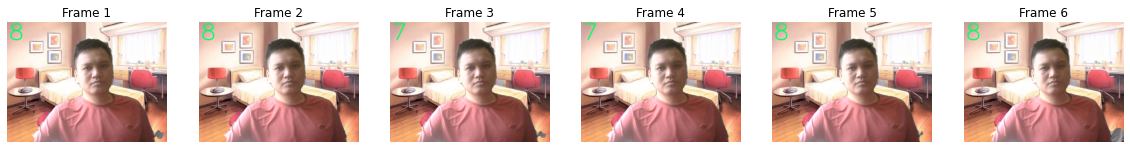

In [8]:
count = len(myframes)
fig, axes = plt.subplots(1, 6, figsize=(20, 20))

for idx, ax in enumerate(axes.flat):
    count = count - 1
    ax.imshow(cv2.cvtColor(myframes[count], cv2.COLOR_BGR2RGB))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()

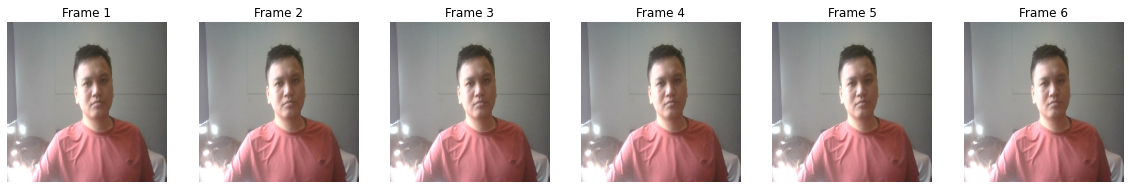

In [9]:
count = len(input_frames)
fig, axes = plt.subplots(1, 6, figsize=(20, 20))

for idx, ax in enumerate(axes.flat):
    count = count - 1
    ax.imshow(cv2.cvtColor((input_frames[count][0]*255).astype(np.uint8),cv2.COLOR_BGR2RGB))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()

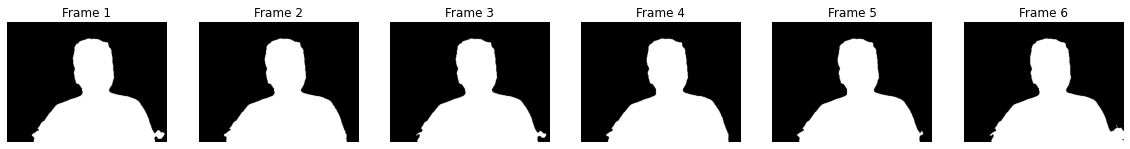

In [10]:
count = len(mask_frame)
fig, axes = plt.subplots(1, 6, figsize=(20, 20))

for idx, ax in enumerate(axes.flat):
    count = count - 1
    ax.imshow(cv2.cvtColor(mask_frame[count], cv2.COLOR_BGR2RGB))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()